In [1]:
import pandas as pd
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from utils import text_to_embeddings,image_to_embeddings,text_matching

In [20]:
file_path = '/Users/kabir/FRE-7773-Project/data/clean_data/products.csv'  
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,ProductID,Description,Name,Type,Color,Size,Image
0,0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",Not known,images/objects/500.210.76.jpg
1,1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
2,2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
3,3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80 cm",images/objects/802.962.48.jpg
4,4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30 cm,images/objects/502.962.97.jpg


In [21]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,ProductID,Description,Name,Type,Color,Size,Image
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",Not known,images/objects/500.210.76.jpg
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200 cm,images/objects/802.538.09.jpg
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80 cm",images/objects/802.962.48.jpg
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30 cm,images/objects/502.962.97.jpg


In [22]:
# Replace 'cm' with an empty string in the 'Size' column
data['Size'] = data['Size'].str.replace('cm', '', regex=False)

# Replace 'Not known' with '0x0' in the 'Size' column
data['Size'] = data['Size'].replace('Not known', '0x0')

# Display the first few rows to verify the changes
data.head()


,ProductID,Description,Name,Type,Color,Size,Image
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg


In [23]:
# Frequency of unique values in the 'Name' column
name_counts = data['Name'].value_counts()

# Frequency of unique values in the 'Type' column
type_counts = data['Type'].value_counts()

# Frequency of unique values in the 'Color' column
color_counts = data['Color'].value_counts()

# Print the frequencies
print("Frequency of Unique Values in 'Name':\n", name_counts)
print("\nFrequency of Unique Values in 'Type':\n", type_counts)
print("\nFrequency of Unique Values in 'Color':\n", color_counts)


Frequency of Unique Values in 'Name':
 HEMNES       54
STOCKHOLM    35
IKEA 365+    25
GODMORGON    25
STUVA        25
             ..
BERTIL        1
STCITRON      1
KERMADD       1
LNNERN        1
MATREDAL      1
Name: Name, Length: 838, dtype: int64

Frequency of Unique Values in 'Type':
 Mirror                           57
Quilt cover and 4 pillowcases    55
Table                            45
Rug, flatwoven                   41
Cushion cover                    39
                                 ..
Valet stand                       1
Box file, set of 3                1
Clothes rack, in,outdoor          1
Chest of 7 drawers                1
Canopy                            1
Name: Type, Length: 611, dtype: int64

Frequency of Unique Values in 'Color':
 White                                  461
Black                                  117
Not known                              100
Grey                                    99
Stainless steel                         66
                 

In [24]:
# Function to process descriptions in batches and generate embeddings
def process_in_batches(function, data, batch_size=128):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_embeddings = function(batch)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Extract descriptions from the DataFrame
descriptions = data['Description'].tolist()

# Generate embeddings in batches
desc_embeddings = process_in_batches(text_to_embeddings, descriptions)

# Add embeddings to the DataFrame
data['desc_embeddings'] = list(desc_embeddings)

# Display the DataFrame to verify
data.head()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861..."


In [25]:
data.tail()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings
2188,401.538.59,Not known,KRITTER,Children's table,White,59x50,images/dining table/401.538.59.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2189,402.675.68,Not known,MAMMUT,Children's table,"In,outdoor light pink",77x55,images/dining table/402.675.68.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2190,902.224.07,Not known,INGATORP,Extendable table,Black,"155,215x87",images/dining table/902.224.07.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2191,402.866.04,Not known,NATTLJUS,Quilt cover and 4 pillowcases,Beige,"200x200,50x80",images/couch/402.866.04.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."
2192,403.000.11,Not known,MATREDAL,Mirror,White,60x90,images/mirror/403.000.11.jpg,"[-0.10089192, -0.08582597, -0.052570224, -0.08..."


In [26]:
# Concatenate the color, type, and size information into a single string for each product
data['combined_attributes'] = data['Color'] + " " + data['Type'] + " " + data['Size']

# Extract the combined strings
combined_strings = data['combined_attributes'].tolist()

# Generate embeddings for the combined strings
combined_embeddings = process_in_batches(text_to_embeddings, combined_strings)

# Add the combined embeddings to the DataFrame
data['feature_embeddings'] = list(combined_embeddings)

# Display the DataFrame to verify
print(data.head())


    ProductID                                        Description     Name  \
0  500.210.76  Your child can use it for different purposes. ...      MLA   
1  802.538.09  Turned upside down the bed quickly converts fr...     KURA   
2  802.538.09  Turned upside down the bed quickly converts fr...     KURA   
3  802.962.48  Made from 100% cotton, a natural material that...  STICKAT   
4  502.962.97  Clever storage solution that you can hang on o...  STICKAT   

                         Type            Color            Size  \
0                       Easel   Softwood,white             0x0   
1              Reversible bed       White,pine         90x200    
2              Reversible bed       White,pine         90x200    
3  Quilt cover and pillowcase  Turquoise,lilac  150x200,50x80    
4                  Bed pocket           Orange          39x30    

                           Image  \
0  images/objects/500.210.76.jpg   
1  images/objects/802.538.09.jpg   
2  images/objects/802.538.09.jpg

In [27]:
data.head()

,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings,combined_attributes,feature_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483...","Softwood,white Easel 0x0","[-0.028281346, -0.21081032, 0.36208922, 0.3940..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","White,pine Reversible bed 90x200","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","White,pine Reversible bed 90x200","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041...","Turquoise,lilac Quilt cover and pillowcase 150...","[0.5114964, 0.13908707, -0.21906427, -0.074509..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861...",Orange Bed pocket 39x30,"[0.21352807, 0.25319734, 0.17924494, 0.3818012..."


In [28]:
# Drop the 'combined_attributes' column from the DataFrame
data = data.drop('combined_attributes', axis=1)

# Display the first few rows to verify the column is removed
data.head()


,ProductID,Description,Name,Type,Color,Size,Image,desc_embeddings,feature_embeddings
0,500.210.76,Your child can use it for different purposes. ...,MLA,Easel,"Softwood,white",0x0,images/objects/500.210.76.jpg,"[0.22380528, -0.2975777, 0.17450377, 0.1160483...","[-0.028281346, -0.21081032, 0.36208922, 0.3940..."
1,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
2,802.538.09,Turned upside down the bed quickly converts fr...,KURA,Reversible bed,"White,pine",90x200,images/objects/802.538.09.jpg,"[0.17816386, 0.19662763, -0.05641848, -0.14517...","[-0.09165584, 0.13867763, 0.09782371, 0.165967..."
3,802.962.48,"Made from 100% cotton, a natural material that...",STICKAT,Quilt cover and pillowcase,"Turquoise,lilac","150x200,50x80",images/objects/802.962.48.jpg,"[0.012026191, 0.025981635, 0.16163956, 0.32041...","[0.5114964, 0.13908707, -0.21906427, -0.074509..."
4,502.962.97,Clever storage solution that you can hang on o...,STICKAT,Bed pocket,Orange,39x30,images/objects/502.962.97.jpg,"[0.2172483, -0.0683471, 0.13148291, 0.15423861...","[0.21352807, 0.25319734, 0.17924494, 0.3818012..."


In [29]:
type(data['desc_embeddings'][1])

numpy.ndarray

In [30]:
data.to_pickle('/Users/kabir/FRE-7773-Project/data/clean_data/product_embeddings.pkl')

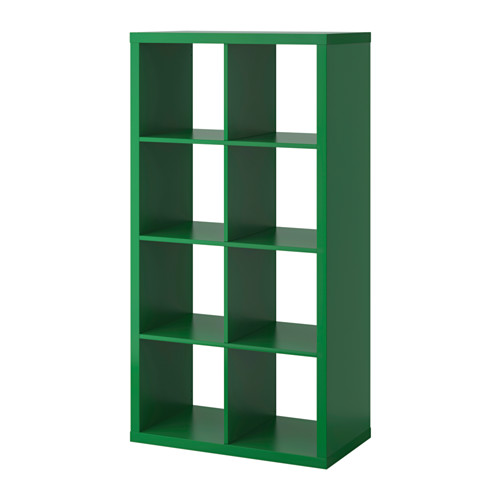

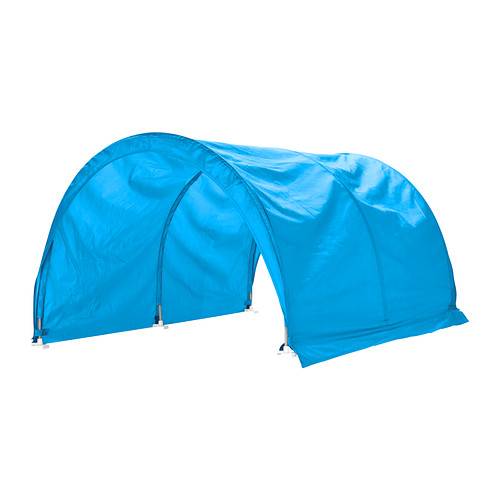

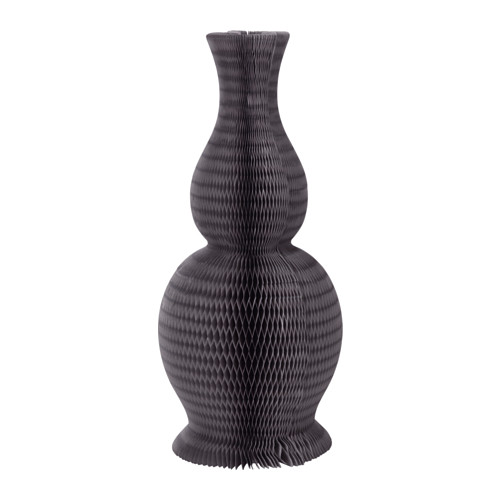

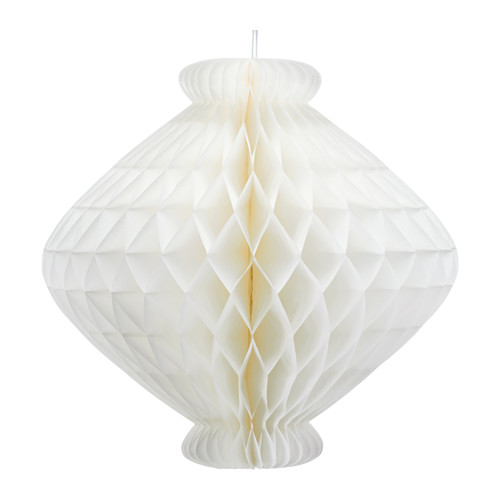

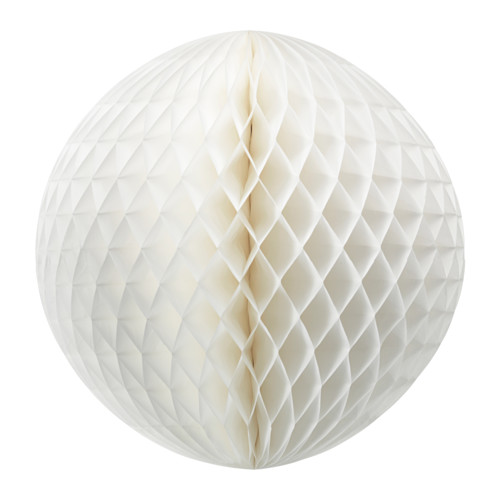

Most Similar Product:        ProductID                                        Description     Name  \
1544  203.002.86  You can use the furniture as a room divider be...   KALLAX   
282   402.965.99    Fits the bed both in a low and a high position.     KURA   
1583  203.067.35  A surprising and playful decoration that will ...  VISIONR   
1489  903.067.32  A surprising and playful decoration that will ...  VISIONR   
1488  103.067.26  A surprising and playful decoration that will ...  VISIONR   

                    Type      Color     Size                          Image  \
1544       Shelving unit      Green  77x147   images/objects/203.002.86.jpg   
282             Bed tent  Turquoise      0x0  images/objects/402.965.99.jpg   
1583          Decoration  Dark grey      50   images/objects/203.067.35.jpg   
1489  Hanging decoration      White      36   images/objects/903.067.32.jpg   
1488  Hanging decoration      White      31   images/objects/103.067.26.jpg   

                      

In [2]:
input_string = 'I want to setup a bedroom for my children with play area, bed and some side tables and I want the theme of the room to be in green color'
data_file='/Users/kabir/FRE-7773-Project/data/clean_data/product_embeddings.pkl'
similar_product, time_taken = text_matching(input_string, data_file)
print("Most Similar Product:", similar_product)
print("Time Taken:", time_taken, "seconds")